
EN ESTE SCRIPT SE EVALUA COMO ES EL ERROR DE LA RED CUANDO LA SALIDA LA 
DAMOS COMO DESPLAZAMIENTOS ES DECIR DX, DY, AL PREDECIR POSICIONES FUTURAS EN UNA TRAYECTORIA.

EN PARTICULAR SE TRABAJA CON EL CONJUNTO DE DATOS DE PETS-S2L1 EN COORDENADAS PIXEL NORMALIZADAS

In [1]:
import os
import pickle
import numpy 
#import pandas as pd
#import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pylab import *
from matplotlib import pyplot

from scipy. ndimage import filters
import pandas as pd
import os
from keras.models import Model, Sequential, save_model, load_model
import math
from sklearn.metrics import mean_squared_error

import random
from sklearn.preprocessing import MinMaxScaler
import h5py
import tensorflow as tf


Using TensorFlow backend.


In [2]:
import os 
import pickle
import numpy as np
import random

def preprocess(data_dirs, data_file,name):
    # all_ped_data would be a dictionary with mapping from each ped to their
    # trajectories given by matrix 3 x numPoints with each column
    # in the order x, y, frameId
    # Pedestrians from all datasets are combined
    # Dataset pedestrian indices are stored in dataset_indices
    all_ped_data = {}
    dataset_indices = []
    current_ped = 0
    # For each dataset
    for directory in data_dirs:
        # Define the path to its respective csv file
        file_path = os.path.join(directory,name )

        # Cargar datos desde el archivo csv
        # Los datos son una matriz 4x numTrajPoints
        data = np.genfromtxt(file_path, delimiter=',')
       
        # Obtenga el numero de peatones en el conjunto de datos actual
        #uni = np.unique(data[:,1])    
        numPeds = np.size(np.unique(data[:,1]))
     
        print("El numero de peatones en "+directory+" es de "+str(numPeds))
       
        # Para cada peaton en el conjunto de datos
        for ped in range(1, numPeds+1):
            #Son los datos de la persona ped
            traj = data[ data[:, 1] == ped]
            
            #Esta como (x,y,frame_Id)
            traj = traj[:, [2,3,0]]
            
            #Esta como [[x,...],[y,...],[Frame_Id,..]]
            traj=[list(traj[:,0]),list(traj[:,1]),list(traj[:,2])]
            all_ped_data[current_ped + ped] = np.array(traj)

        # Current dataset done
        dataset_indices.append(current_ped+numPeds)
        current_ped += numPeds

    # Los datos completos son una tupla de todos los datos de peatones y los indices de datos del conjunto de datos.
    complete_data = (all_ped_data, dataset_indices)
    # Almacena los datos completos en el archivo pickle
    f = open(data_file, "wb")
    pickle.dump(complete_data, f, protocol=2)
    f.close()
    return complete_data
    

In [3]:
def load_preprocessed(data_file,seq_length_obs,batch_size):
    
    # cargar los datos
    f = open(data_file, "rb")
    raw_data = pickle.load(f)
    f.close()

    # Obtengo los peatones
    all_ped_data =raw_data[0]
 
    #all_ped_data es el vector {[[],[],[]],...,[[],[],[]]} tantos como pedestrian hayan
    # No usamos dataset_indices por ahora
    # dataset_indices = self.raw_data[1]

    # Construimos data con secuencias(o trayectorias) del largo than seq_length_obs
    data = []
    counter = 0

    # para cada peaton en data
    for ped in all_ped_data:
        
        #ped es un numero entero y va de 1 hasta la cantidad total de pedestrian
        # Extract his trajectory
        traj = all_ped_data[ped]
        
           
        # If the length of the trajectory is greater than seq_length (+2 as we need both source and target data)
        #solo se toman las trajectorias de longitud mayor a seq_length+2
        if traj.shape[1] >= (seq_length_obs+1):
            # TODO: (Improve) Store only the (x,y) coordinates for now
               
            data.append(traj[[0, 1], :].T)
            #print(traj[[0, 1], :].T)
            # Number of batches this datapoint is worth
            #print(traj.shape[1] )
            #print(int(traj.shape[1] / ((seq_length_obs+1))))
            counter += int(traj.shape[1] / ((seq_length_obs+1)))
        
    # Calculate the number of batches (each of batch_size) in the data
    #counter tiene la cantidad de bloques de 8 pasos
        
    num_batches = int(counter /batch_size)
    #cada bache tiene batch_size conjuntos donde cada conjunto tiene datos de length+2
    return data,num_batches

In [4]:

"""
Cuando se entrena con un solo dataset y a este se divide en training y test
"""
data_dirs = ['../data1/pets']
datasets=[0]

used_data_dirs = [data_dirs[x] for x in datasets]
      
# Directorio de datos donde reside el archivo pickle preprocesado
data_dir = '../data1'

# Defina la ruta del archivo en el que deben almacenarse los datos.
data_file = os.path.join(data_dir, "datos_limpios_solo.cpkl")

# Para pets si se usa pixel_pos.csv es el de framerate 7.5
# Para pets si se usa pixel_pos_2.csv es el de framerate 3.25

name = 'pixel_pos.csv'

#datos tiene todos las trayectorias de todos los peatones 
data = preprocess(used_data_dirs, data_file,name)
datos,numero = load_preprocessed(data_file,12,1)#los ultimos dos valores noimportan

El numero de peatones en ../data1/pets es de 19


In [5]:
def secuencia(seq_length_obs,data):
    """
    ESTA FUNCION SE ENCARGA DE DIVIDIR LAS SUCESIONES DE LOS PEATONES EN 
    LA SUCESION OBSERVA DE LONGITUD SEQ_LENGTH_OBS Y EL PREDICHO DE LONGITUD 1.
    """
    tamano = int(len(data))
    
    X,Y = [],[]
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-seq_length_obs-1
        for i in range(0,lon+1):
            a = traj[i:(i +seq_length_obs ), :]
            X.append(a)
            b = traj[i+seq_length_obs, :]  
            Y.append(b-a[len(a)-1,:])
    return np.array(X), np.array(Y)

## VISUALIZANDO LOS DATOS

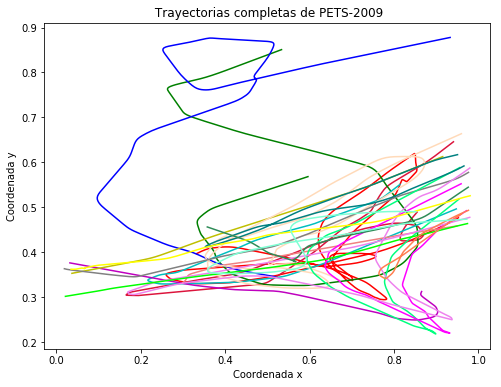

In [6]:
plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
color_names = ["r","crimson" ,"g", "b","c","m","y","lightcoral", "peachpuff","grey","springgreen" ,"fuchsia","violet","teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]
for i in range(len(datos)):
    cpu = random.choice(range(17))
    pintar=plt.plot(datos[i][:,0],datos[i][:,1],color=color_names[i])
plt.title(" Trayectorias completas de PETS-2009") 
plt.xlabel("Coordenada x")   
plt.ylabel("Coordenada y") 

#plt.savefig("trayectorias.jpg")
plt.show() 

## Se divide los indices del conjunto de dato para hacer validación cruzada, cuando se entrena con  pets 

In [ ]:

"""
LO QUE SE HACE ES QUE COMO PETS TIENE 19 PEATONES, COMBINACIONES DE LOS ID-PERSON 
PARA HACER 5 DISTINTOS CONJUNTOS DE ENTRENAMIENTO CON SU RESPECTIVO CONNJUNTO DE PRUEBA
"""

longitud=len(datos)
ind = range(longitud)

lista = []
for i in range(0,longitud,4):
    lista.append(ind[i:i+4])
#print(lista)

combinacion=[(0,1,2,3,4),(0,1,2,4,3),(0,1,3,4,2),(0,2,3,4,1),(1,2,3,4,0)]

def conjunto_datos(combinacion,lista,datos):
    conjunto_entrenamiento = []
    for i in range(len(combinacion)-1):
       # print(i)
        for j in lista[combinacion[i]]:
        #    print(j)
            conjunto_entrenamiento.append(datos[j])
    conjunto_prueba=[]
    for i in lista[combinacion[4]]:
        #print(i)
        conjunto_prueba.append(datos[i])
    
    return conjunto_entrenamiento,conjunto_prueba

In [ ]:
train1,test1 = conjunto_datos(combinacion[0],lista,datos)
train2,test2 = conjunto_datos(combinacion[1],lista,datos)
train3,test3 = conjunto_datos(combinacion[2],lista,datos)
train4,test4 = conjunto_datos(combinacion[3],lista,datos)
train5,test5 = conjunto_datos(combinacion[4],lista,datos)


In [ ]:
length_obs = 8
trainX,trainY = secuencia(length_obs,train5)
#valiX, valiY= secuencia(length_obs,vali2)

In [ ]:
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1],trainX.shape[2]))
#valiX = numpy.reshape(valiX, (valiX.shape[0], valiX.shape[1],valiX.shape[2]))

In [ ]:
data_shape =trainX.shape[1:]
print(data_shape)
import numpy as np
np.shape(trainX)

## DIVIDIENDO CONJUNTO DE TRAINING, TESTING AND VALIDATION

## Aqui dividimos el conjunto

### CALCULAMOS LOS CONJUNTOS DE DATOS

### SE LE DA LA FORMA QUE NECESITAN LOS DATOS PARA LA RED

## SE DISEÑA LA RED

In [ ]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras import initializers
from datetime import datetime

if 'model' in globals(): del model
model = None
model = Sequential()
model.add(LSTM(9, return_sequences=True, input_shape=data_shape, name='lstm1'))
model.add(LSTM(9, name='lstm2'))
model.add(Dense(2))

In [ ]:
model.summary()

In [ ]:
#,validation_data=(valiX,valiY)
from time import time
opt = optimizers.RMSprop(lr = 0.006, decay=1e-2)
start_time = time()
model.compile( optimizer = opt,loss='logcosh',metrics=['mse'])
history1 = model.fit(trainX, trainY, epochs=100, batch_size=15, verbose=2 )
elapsed_time = time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)
#,callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=5, verbose=1)])

In [ ]:
history_dict1 = history1.history
history_dict1.keys()

In [ ]:
mse = history1.history['mean_squared_error']
#val_mse = history1.history['val_mean_squared_error']
loss = history1.history['loss']
#val_loss = history1.history['val_loss']

epochs = range(1, len(mse)+1)

# figure
plt.figure(figsize=(13,7))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
#plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, mse, 'r', label='Training mse')
#plt.plot(epochs, val_mse, 'g', label='Validation mse')
plt.title('Training and validation mse')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
#plt.savefig("lstm-dxdy4-100.pdf")

plt.show()


## GUARDAMOS Y CARGAMOS  LA RED

## Se entrenaron con 80 epocas

 ### Son los de pets con framerate 7.5 frames por segundo

In [ ]:
#model.save('lstm-dxdy0.h5')

In [ ]:
#model.save('lstm-dxdy1.h5')

In [ ]:
#model.save('lstm-dxdy2.h5')

In [ ]:
#model.save('lstm-dxdy3.h5')

In [ ]:
#model.save('lstm-dxdy4.h5')

### Son los de pets con framerate  mas espaciado

In [ ]:
#model.save('lstm-dxdy0-simplificado.h5')

In [ ]:
#model.save('lstm-dxdy1-simplificado.h5')

In [ ]:
#model.save('lstm-dxdy2-simplificado.h5')

In [ ]:
#model.save('lstm-dxdy3-simplificado.h5')

In [ ]:
#model.save('lstm-dxdy4-simplificado.h5')

#  Se entrenaron con 100 epocas

### Son los de pets con un framerate de 7.5 frames por segundo

In [ ]:
#model.save('lstm-dxdy0-100.h5')

In [ ]:
#model.save('lstm-dxdy1-100.h5')

In [ ]:
#model.save('lstm-dxdy2-100.h5')

In [ ]:
#model.save('lstm-dxdy3-100.h5')

In [ ]:
#model.save('lstm-dxdy4-100.h5')

### Son los de pets con un framerate mas espaciado

In [ ]:
#model.save('lstm-dxdy0-simplificado_100.h5')

In [ ]:
#model.save('lstm-dxdy1-simplificado_100.h5')

In [ ]:
#model.save('lstm-dxdy2-simplificado_100.h5')

In [ ]:
#model.save('lstm-dxdy3-simplificado_100.h5')

In [ ]:
#model.save('lstm-dxdy4-simplificado_100.h5')

## Aqui se carga el modelo con el cual se quiere trabajar

In [ ]:
modeldxdy =load_model('lstm-dxdy0.h5')# se le cambia el nombre

## PREDICCION

In [7]:
def error_promedio(predicted_traj, true_traj, seq_length_obs):
    
    error = np.zeros(len(true_traj) - seq_length_obs)
    # PARA CADA PUNTO EN LA TRAYECTORIA PREDICHA
    for i in range(seq_length_obs, len(true_traj)):
        # The predicted position
        pred_pos = predicted_traj[i]
        # The true position
        true_pos = true_traj[i]

        # The euclidean distance is the error
        error[i-seq_length_obs] = np.linalg.norm(true_pos - pred_pos)

    # Return the mean error
    return np.mean(error)


In [8]:
def error_desplazamiento_final(predicted_traj, true_traj):
    tam = len(predicted_traj)
    return np.linalg.norm(predicted_traj[tam-1]-true_traj[tam-1])

In [9]:
def secuencia_pred(seq_length_obs,data,seq_length_pred):
    tamano = int(len(data))
    
    X,Y_true = [],[]
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-seq_length_obs-seq_length_pred
    #lon=data.shape[0]-seq_length_obs-seq_length_pred
        for i in range(0,lon+1):
            a = traj[i:(i +seq_length_obs ), :]
            
            X.append(a)
            
            b = traj[i: (i+seq_length_obs+seq_length_pred), :]
        
            Y_true.append(b)
    return np.array(X),np.array(Y_true)

In [10]:
"""
Esta funcion calcula el error del modelo , al evaluar el conjunto de test
y los resultados estan normalizados
"""

def sample(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    todo = []
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        #print(Y_true[i])
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modeldxdy.predict(traj_obsr)
            next_point = traj_obs[len(traj_obs)-1]+predict
                      
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
            
        diff = Y_true[i][seq_length_obs:]-traj_pred[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
        total_error += error_promedio(traj_pred , Y_true[i], seq_length_obs)
        total_final += error_desplazamiento_final(traj_pred, Y_true[i]) 
        
        
    error_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    ade=[t for o in todo for t in o]
    
    print('ADE')
    print(np.mean(ade))
    
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)
        
    

In [11]:
"""
Esta funcion calcula el error del modelo , al evaluar el conjunto de test
y los resultados estan en marco pixeles
"""
def sample_en_pixeles(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    todo = []
    
    
    trayectoria=[]
    verdadero=[]
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modeldxdy.predict(traj_obsr)
            next_point = traj_obs[len(traj_obs)-1]+predict
                      
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
        
        #traj_pre = []
        #traj_tr = []
        #for k in range(len(traj_pred)):
        #    traj_pre.append([640* traj_pred[k,0],480*traj_pred[k,1]])
        #    traj_tr.append([640* Y_true[i][k,0],480*Y_true[i][k,1]])
        
        #traj_pre = np.array(traj_pre)
        #traj_tr = np.array(traj_tr)
        
        traj_pre =  np.column_stack((768*traj_pred[:,0],576*traj_pred[:,1]))
        traj_tr = np.column_stack((768*Y_true[i][:,0],576*Y_true[i][:,1]))
        
        trayectoria.append(traj_pre)
        verdadero.append(traj_tr)
        
        # calcular ADE
        diff = traj_tr[seq_length_obs:]-traj_pre[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
        
        total_error += error_promedio(traj_pre ,traj_tr,seq_length_obs)
        total_final += error_desplazamiento_final(traj_pre, traj_tr)
        
    error_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    ade = [t for o in todo for t in o]
    
    print('ADE')
    print(np.mean(ade))
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)
    return trayectoria, verdadero

In [ ]:
sample(test1,8,4)

In [ ]:
p,v = sample_en_pixeles(test1,8,4)

In [12]:
def secuencia_x_persona(seq_length_obs,data,seq_length_pred):
    tamano = int(len(data))
    X,Y_true = [],[]
    for j in range(tamano):
        traj = data[j]
        X.append(traj[0:seq_length_obs,:])
        Y_true.append(traj[0:seq_length_obs+seq_length_pred,:])
    return np.array(X),np.array(Y_true)

In [ ]:
"""
Esta función predice las posiciones futuras de los peatones tomando como observada las primeras Tobs 
posiciones del peaton y los resultados estan normalizados
"""

def sample_x_persona_normalizado(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_x_persona(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    plt.figure(figsize=(18,15))  
    color_names = ["r","crimson" ,"g", "b","c","m","y","lightcoral", "peachpuff","grey","springgreen" ,"fuchsia","violet","teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]
    todo=[]
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modeldxdy.predict(traj_obsr)
            next_point = traj_obs[len(traj_obs)-1]+predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
        
        diff = Y_true[i][seq_length_obs:]-traj_pred[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
     
    
        error_prom = error_promedio(traj_pred ,Y_true[i], seq_length_obs)
        FDE = error_desplazamiento_final(traj_pred , Y_true[i])
        

        print("TRAYECTORIA PREDICHA DEL PEATON ",i+1)
        print(traj_pred)
        print("TRAYECTORIA VERDADERA  ")
        print(Y_true[i])
        print("EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = {:.3f} ".format(error_prom))
        print("ERROR DE DESPLAZAMIENTO FINAL ES ={:.3f}".format(FDE))
                         
        #cpu = random.choice(range(17))
                         
        subplot(1,1,1)
        
        predicha=plt.plot(Y_true[i][:12,0],Y_true[i][:12,1],'*--',color=color_names[19-i])
        predicha=plt.plot(traj_pred[seq_length_obs:(seq_length_obs+seq_length_pred),0],
                                  traj_pred[seq_length_obs:(seq_length_obs+seq_length_pred),1],'o--',color=color_names[i])
        plt.title("Cuatro posiciones predichas con LSTM-DX-DY") 
        plt.xlabel('Coordenada x')
        plt.ylabel('Coordenada y')
        
        
        total_error += error_prom
    error_modelo = total_error/len(X)
    ade=[t for o in todo for t in o]
    
    
    
    print("EL ERROR PROMEDIO DE TODA LA PREDICCIÓN")
    print(error_modelo)
    print('ADE')
    print(np.mean(ade))
    plt.savefig("4prediccion.pdf")
    plt.show()
    
        

In [ ]:

"""
Esta función predice las posiciones futuras de los peatones tomando como observada las primeras Tobs 
posiciones del peaton y los resultados estan en marco pixel
"""



def sample_x_persona(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_x_persona(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    plt.figure(figsize=(18,15))  
    color_names = ["r", "g", "b","c","m","y", "peachpuff","grey", "fuchsia","violet",
                   "teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]
    todo=[]
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modeldxdy.predict(traj_obsr)
            next_point = traj_obs[len(traj_obs)-1]+predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
    
        traj_pre = []
        traj_tr = []
        for k in range(len(traj_pred)):
            traj_pre.append([768* traj_pred[k,0],576*traj_pred[k,1]])
            traj_tr.append([768* Y_true[i][k,0],576*Y_true[i][k,1]])
        
        traj_pre=np.array(traj_pre)
        traj_tr=np.array(traj_tr)
        error_prom = error_promedio(traj_pre , traj_tr, seq_length_obs)
        FDE = error_desplazamiento_final(traj_pre , traj_tr)
        
        diff = traj_tr[seq_length_obs:]-traj_pre[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
    

        print("TRAYECTORIA PREDICHA DEL PEATON ",i+1)
        print(traj_pre)
        print("TRAYECTORIA VERDADERA  ")
        print(traj_tr)
        print("EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = {:.3f} ".format(error_prom))
        print("ERROR DE DESPLAZAMIENTO FINAL ES ={:.3f}".format(FDE))
                         
        cpu = random.choice(range(17))
                         
        subplot(1,1,1)
        
        predicha=plt.plot(traj_tr[:,0],traj_tr[:,1],'*--',color=color_names[cpu])                
        predicha=plt.plot(traj_pre[seq_length_obs:(seq_length_obs+seq_length_pred),0],
                                  traj_pre[seq_length_obs:(seq_length_obs+seq_length_pred),1],'o--',color=color_names[cpu])
        
        plt.title("Cuatro posiciones predichas con LSTM-DX-DY") 
        plt.xlabel('Coordenada x')
        plt.ylabel('Coordenada y')
        
        
        total_error += error_prom
    error_modelo = total_error/len(X)
    
    ade=[t for o in todo for t in o]
    print("EL ERROR PROMEDIO DE TODA LA PREDICCIÓN")
    print(error_modelo)
    print("Error ADE")
    print(np.mean(ade))
    plt.savefig("trayectoriasdxdy.pdf")
    plt.show()
    
        
    
    

In [ ]:
sample_x_persona(test5,8,4)

In [ ]:
sample_x_persona_normalizado(test5,8,4)

## Analisis cualitativo

In [13]:
cruce = []
cruce.append(datos[3][252:264,:])
cruce.append(datos[4][135:147,:])

paralelos = []
paralelos.append(datos[2][1:13])
paralelos.append(datos[3][20:32])

inverso = []
inverso.append(datos[4][167:179])
inverso.append(datos[6][15:27])

In [14]:
cruce[0]

array([[0.30011341, 0.40633819],
       [0.30590104, 0.40479427],
       [0.31172969, 0.40319566],
       [0.3176612 , 0.40145833],
       [0.32378333, 0.39946319],
       [0.33016445, 0.39711771],
       [0.3368043 , 0.39442187],
       [0.34361732, 0.39148264],
       [0.35047604, 0.38845035],
       [0.35723346, 0.3854776 ],
       [0.36374049, 0.38270017],
       [0.36989193, 0.38021059]])

In [15]:
def grafica(p,v,name):
    color_names = ["r", "g", "b","c","m","y", "peachpuff","grey", "fuchsia","violet",
                   "teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]
    
    plot(p[0][0:8,0],p[0][0:8,1],'*--',color= color_names[10],label = 'Observed')
    plot(p[0][7:,0],p[0][7:,1],'-',color=color_names[10],label='Predicted')
    plot(v[0][7:,0],v[0][7:,1],'--',color=color_names[4],label='Ground truth')
    
    plot(p[1][0:8,0],p[1][0:8,1],'*--',color= color_names[10])
    plot(p[1][7:,0],p[1][7:,1],'-',color=color_names[10])
    plot(v[1][7:,0],v[1][7:,1],'--',color=color_names[4])
    
    plt.legend()
    plt.savefig(name)
    plt.show()

W0325 15:38:34.311696 140007622182656 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0325 15:38:34.328618 140007622182656 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0325 15:38:34.331933 140007622182656 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0325 15:38:34.701560 140007622182656 deprecation_wrapper.py:119] From /home/andrea/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_se

ADE
3.0272289140720843
3.0272289140720843
FDE
4.814155141324991


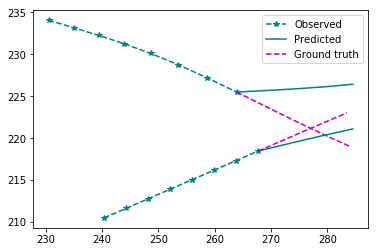

In [16]:
"""
Para graficar los resultados cualitativos se escoge el mejor modelo de los 
5,  para pets con framerate 7.5
"""
modeldxdy =load_model('lstm-dxdy3.h5')# se le cambia el nombre
band = 0
if(band==0):
    p,v = sample_en_pixeles(cruce,8,4)
    name = "cruce_des_ing.pdf"
elif(band==1):
    p,v = sample_en_pixeles(paralelos,8,4)
    name = "paralelos_des_ing.pdf"
else:
    p,v = sample_en_pixeles(inverso,8,4)
    name = "inverso_des_ing.pdf"
grafica(p,v,name)